<b>Hyperparameters</b>: 
<br><b>win_tol</b>: window tolerance within which if a method detected cp, count that as true changepoint detected
<br>win_tol=2
<br>For BOCD: <b>run_length_threshold</b> - the change in run_length that constitutes a changepoint, for example if run_length_threshold is set to 4, then if run length drops by 4 or more, then that constitutes a changepoint
<br>For gradient based: <b>gradient_threshold</b>: the threshold above which a change in gradient constitutes a changepoint.
<br>For MC_dropout: <b>mc_dropout_threshold</b>: the threshold above which a change in variance in any of the output dimensions constitutes a changepoint
<br>
<br> <b>If TP=FP=0, Precision=1 rather than 0 and if TP=FN=0, then Recall=1 rather than 0 
<br> zero division is taken as 1 and not 0 for Precision and Recall</b>
<br> example: true_cps = [3, 31, 250, 273], pred_cps = [30, 31, 249, 250, 272, 300]
<br> TP = 3, FP = 1, FN = 1, TN = 317-5 = 312
<br> true changepoint 3 could not be detected but the rest were detected within the window tolerance
<br> false changepoint 300 was detected
<br>
<br>Precision = TP/(TP+FP)
<br>Recall or A_cp = TP/(TP+FN)
<br>A_cp = Accuracy for detecting changepoints (minority class)
<br>Accuracy = (TP+TN)/(TP+TN+FP+FN)
<br>A_major or A_no_cp = TN/(TN+FP)
<br>A_major or A_no_cp = Accuracy for detecting points that are not changepoints (majority class)
<br>Balanced_Accuracy = 1/2*(A_cp+A_major)

In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from   matplotlib.colors import LogNorm
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score, auc
from sklearn import metrics

In [2]:
root_dir = "/home/users/richras/Ge2Net_Repo"
os.chdir(root_dir)

In [3]:
!./ini.sh

set environment variables
All done


In [4]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [5]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred, computePrMetric
from src.main.settings_model import parse_args, MODEL_CLASS
import test

# load the model and use valid data to choose hyperpparams for the different cp methods

In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_11_data_id_3_pca/') 
dataset_type='valid'

In [7]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, valid_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 28.5757 secs
Finished '__init__' in 96.8344 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'gcd': None, 'mse': 0.1995547962085692, 'smooth_l1': 0.09504288945520127, 'weighted_loss': 0.34293384256433385, 'loss_main': 0.34293384256433385, 'loss_aux': 0.8663749794061406}
at epoch : 87
train loss metrics: {'gcd': None, 'mse': 0.10320528280809713, 'smooth_l1': 0.04959562086833885, 'weighted_loss': 0.2486219141212711, 'loss_main': 0.2296785485357874, 'loss_aux': 0.9173492295086926}
best val cp metrics : {'loss_cp': 0.07215550060296119, 'prMetrics': OrderedDict([('Precision', array(0.83539936)), ('Recall', array(0.41389135)), ('Accuracy', array(0.99088631)), ('A_major', array(0.99887142)), ('BalancedAccuracy', 0.7063813850019123)])}
train cp metrics: {'loss_cp': 0.20510284079111923, 'prMetrics': O

In [8]:
results.t_accr, results.t_cp_accr

({'gcd': None,
  'loss_aux': 0.9038384894505423,
  'loss_main': 0.33668436922696726,
  'mse': 0.17734042670814248,
  'smooth_l1': 0.08508031562959142,
  'weighted_loss': 0.33668436922696726},
 {'loss_cp': 0.20465141559150965,
  'prMetrics': OrderedDict([('Precision', array(0.02089126)),
               ('Recall', array(0.89707176)),
               ('Accuracy', array(0.71016378)),
               ('A_major', array(0.70886952)),
               ('BalancedAccuracy', 0.8029706389012661)])})

In [9]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [10]:
def reportChangePointMetrics1(name : str, cp_pred_raw: torch.Tensor, cp_target: torch.tensor, cpThresh: float, win_tol=2)->t_prMetrics:
    Batch_size, T = cp_target.shape[0], cp_target.shape[1]
    cp_pred = getCpPred(name, cp_pred_raw, cpThresh, Batch_size, T)
    prCounts = eval_cp_batch(cp_target, cp_pred, T, win_tol=win_tol)
    prMetrics = computePrMetric(prCounts)
    print(f"prCounts:{prCounts}")

    return prMetrics, cp_pred

In [11]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics1(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['A_major']=(2*prMetrics['BalancedAccuracy'])-prMetrics['Recall']
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

# neural network, choose the threshold for logits

In [12]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5)
df_nn.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=7153.0, FP=335486.0, TN=813607.0, FN=804.0)
prCounts:PrCounts(TP=7153.0, FP=335458.0, TN=813635.0, FN=804.0)
prCounts:PrCounts(TP=7150.0, FP=335439.0, TN=813654.0, FN=807.0)
prCounts:PrCounts(TP=7148.0, FP=335412.0, TN=813681.0, FN=809.0)
prCounts:PrCounts(TP=7147.0, FP=335376.0, TN=813717.0, FN=810.0)
prCounts:PrCounts(TP=7145.0, FP=335331.0, TN=813762.0, FN=812.0)
prCounts:PrCounts(TP=7145.0, FP=335271.0, TN=813822.0, FN=812.0)
prCounts:PrCounts(TP=7143.0, FP=335186.0, TN=813907.0, FN=814.0)
prCounts:PrCounts(TP=7140.0, FP=335079.0, TN=814014.0, FN=817.0)
prCounts:PrCounts(TP=7139.0, FP=334881.0, TN=814212.0, FN=818.0)
prCounts:PrCounts(TP=7138.0, FP=334536.0, TN=814557.0, FN=819.0)
prCounts:PrCounts(TP=4019.0, FP=4872.0, TN=1144221.0, FN=3938.0)
prCounts:PrCounts(TP=3774.0, FP=3328.0, TN=1145765.0, FN=4183.0)
prCounts:PrCounts(TP=3576.0, FP=2415.0, TN=1146678.0, FN=4381.0)
prCounts:PrCounts(TP=3383.0, FP=1768.0, TN=1147325.0, FN=4574.0)
prCounts:PrCounts(TP=3139

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.02087619914837482,0.8989568933014955,0.7093556890367746,0.7080427780867171,0.803500,0.400000,0.040805
1,0.02087790526281993,0.8989568933014955,0.7093798885095718,0.7080671451309859,0.803512,0.405000,0.040808
2,0.020870489128372482,0.8985798667839638,0.7093937167797416,0.7080836799110255,0.803332,0.410000,0.040794
3,0.02086641756188697,0.898328515772276,0.709415323451882,0.7081071767037133,0.803218,0.415000,0.040785
4,0.02086575208088216,0.898202840266432,0.7094455727928785,0.7081385057606303,0.803171,0.420000,0.040784
5,0.02086277578574849,0.8979514892547442,0.7094827362689599,0.7081776670817767,0.803065,0.425000,0.040778
6,0.02086643147516471,0.8979514892547442,0.7095345922820967,0.7082298821766384,0.803091,0.430000,0.040785
7,0.02086589216806055,0.8977001382430564,0.7096063264336027,0.708303853561026,0.803002,0.435000,0.040784
8,0.02086383280881541,0.8973231117255247,0.7096962101897066,0.7083969704801961,0.802860,0.440000,0.040779
9,0.020873048359745044,0.8971974362196807,0.7098664707661726,0.70856928029324,0.802883,0.445000,0.040797


In [13]:
nnThresh=0.47

# gradient method, choose the threshold for gradient difference in predictions

In [14]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1)
df_grad.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=7957.0, FP=1114866.0, TN=34227.0, FN=0.0)
prCounts:PrCounts(TP=6211.0, FP=53208.0, TN=1095885.0, FN=1746.0)
prCounts:PrCounts(TP=5844.0, FP=22638.0, TN=1126455.0, FN=2113.0)
prCounts:PrCounts(TP=5591.0, FP=13266.0, TN=1135827.0, FN=2366.0)
prCounts:PrCounts(TP=5379.0, FP=8776.0, TN=1140317.0, FN=2578.0)
prCounts:PrCounts(TP=5205.0, FP=6082.0, TN=1143011.0, FN=2752.0)
prCounts:PrCounts(TP=5051.0, FP=4465.0, TN=1144628.0, FN=2906.0)
prCounts:PrCounts(TP=4903.0, FP=3425.0, TN=1145668.0, FN=3054.0)
prCounts:PrCounts(TP=4764.0, FP=2689.0, TN=1146404.0, FN=3193.0)
prCounts:PrCounts(TP=4614.0, FP=2146.0, TN=1146947.0, FN=3343.0)
prCounts:PrCounts(TP=4479.0, FP=1733.0, TN=1147360.0, FN=3478.0)
prCounts:PrCounts(TP=4357.0, FP=1382.0, TN=1147711.0, FN=3600.0)
prCounts:PrCounts(TP=4211.0, FP=1090.0, TN=1148003.0, FN=3746.0)
prCounts:PrCounts(TP=4088.0, FP=881.0, TN=1148212.0, FN=3869.0)
prCounts:PrCounts(TP=3960.0, FP=738.0, TN=1148355.0, FN=3997.0)
prCounts:PrCounts(TP=3837.

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007086602251646075,1.0,0.03645823430275269,0.029786100863898744,0.514893,0.000000,0.014073
1,0.10452885440683957,0.7805705667965314,0.952505077567953,0.9536956538765792,0.867133,0.050000,0.184368
2,0.20518222034969455,0.7344476561518161,0.9786085303141611,0.9802992447086528,0.857373,0.100000,0.320755
3,0.2964946704141698,0.7026517531733065,0.9864897800440776,0.9884552425260619,0.845553,0.150000,0.417021
4,0.38000706464146944,0.6760085459343974,0.9901871137807355,0.9923626721248846,0.834186,0.200000,0.486523
5,0.4611499955701249,0.6541410079175569,0.9923650663324834,0.9947071298841782,0.824424,0.250000,0.540948
6,0.5307902480033627,0.6347869800175946,0.9936294887861371,0.996114326690703,0.815451,0.300000,0.578149
7,0.5887367915465899,0.6161870051526958,0.994400414848105,0.9970193883349737,0.806603,0.350000,0.602149
8,0.6392056889843016,0.5987181098403921,0.9949163821788168,0.9976598934986115,0.798189,0.400000,0.618300
9,0.6825443786982248,0.5798667839638054,0.9952560390648633,0.9981324401071106,0.789000,0.450000,0.627030


In [15]:
gradThresh=0.3

# mc dropout variance, choose the threshold for difference in variance

In [16]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.25)
df_var.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=7957.0, FP=1118498.0, TN=30595.0, FN=0.0)
prCounts:PrCounts(TP=6250.0, FP=188553.0, TN=960540.0, FN=1707.0)
prCounts:PrCounts(TP=5689.0, FP=125624.0, TN=1023469.0, FN=2268.0)
prCounts:PrCounts(TP=5208.0, FP=93864.0, TN=1055229.0, FN=2749.0)
prCounts:PrCounts(TP=4767.0, FP=75362.0, TN=1073731.0, FN=3190.0)
prCounts:PrCounts(TP=4336.0, FP=63303.0, TN=1085790.0, FN=3621.0)
prCounts:PrCounts(TP=3902.0, FP=54234.0, TN=1094859.0, FN=4055.0)
prCounts:PrCounts(TP=3515.0, FP=47158.0, TN=1101935.0, FN=4442.0)
prCounts:PrCounts(TP=3120.0, FP=41646.0, TN=1107447.0, FN=4837.0)
prCounts:PrCounts(TP=2834.0, FP=37009.0, TN=1112084.0, FN=5123.0)
prCounts:PrCounts(TP=2526.0, FP=33146.0, TN=1115947.0, FN=5431.0)
prCounts:PrCounts(TP=2219.0, FP=29832.0, TN=1119261.0, FN=5738.0)
prCounts:PrCounts(TP=1957.0, FP=27063.0, TN=1122030.0, FN=6000.0)
prCounts:PrCounts(TP=1715.0, FP=24567.0, TN=1124526.0, FN=6242.0)
prCounts:PrCounts(TP=1534.0, FP=22270.0, TN=1126823.0, FN=6423.0)
prCounts:PrC

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007063753101544225,1.0,0.033319216974201635,0.026625347121599384,0.513313,0.000000,0.014028
1,0.03208369480962819,0.7854719115244438,0.8355645823430276,0.8359114536421334,0.810692,0.012500,0.061649
2,0.04332396640088948,0.7149679527460098,0.8894671794650187,0.8906755153847425,0.802822,0.025000,0.081697
3,0.052567829457364344,0.6545180344350886,0.9165005833801478,0.9183147055982414,0.786416,0.037500,0.097319
4,0.05949156984362715,0.5990951363579239,0.9321101076012273,0.9344161003504503,0.766756,0.050000,0.108235
5,0.06410502816422478,0.5449289933391982,0.9421598029471501,0.9449104641660858,0.744920,0.062500,0.114715
6,0.06711848080363286,0.4903858238029408,0.9496227475044293,0.9528027757544428,0.721594,0.075000,0.118076
7,0.06936632920884889,0.44174940304134724,0.9554038287023032,0.958960675941808,0.700355,0.087500,0.119904
8,0.0696957512397802,0.3921075782330024,0.9598262823559915,0.963757502656443,0.677933,0.100000,0.118354
9,0.07112918203950505,0.3561643835616438,0.9635867075752993,0.967792859237677,0.661979,0.112500,0.118577


In [17]:
varThresh=0.10

# BOCD, Compute the run lengths and changepoints by using a multivariate Gaussian (with independent three dimensions of predictions) to model the prediction sequence

In [18]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, log_prob_r_joint_x, log_p_xt1_given_xt, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 192.8443 secs


In [28]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20,1,11)
df_bocd.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=3960.0, FP=1740.0, TN=1147353.0, FN=3997.0)
prCounts:PrCounts(TP=3960.0, FP=1740.0, TN=1147353.0, FN=3997.0)
prCounts:PrCounts(TP=4913.0, FP=3634.0, TN=1145459.0, FN=3044.0)
prCounts:PrCounts(TP=4913.0, FP=3634.0, TN=1145459.0, FN=3044.0)
prCounts:PrCounts(TP=5156.0, FP=4774.0, TN=1144319.0, FN=2801.0)
prCounts:PrCounts(TP=5156.0, FP=4774.0, TN=1144319.0, FN=2801.0)
prCounts:PrCounts(TP=5243.0, FP=5486.0, TN=1143607.0, FN=2714.0)
prCounts:PrCounts(TP=5243.0, FP=5486.0, TN=1143607.0, FN=2714.0)
prCounts:PrCounts(TP=5279.0, FP=6018.0, TN=1143075.0, FN=2678.0)
prCounts:PrCounts(TP=5279.0, FP=6018.0, TN=1143075.0, FN=2678.0)
prCounts:PrCounts(TP=5311.0, FP=6462.0, TN=1142631.0, FN=2646.0)
prCounts:PrCounts(TP=5311.0, FP=6462.0, TN=1142631.0, FN=2646.0)
prCounts:PrCounts(TP=5327.0, FP=6803.0, TN=1142290.0, FN=2630.0)
prCounts:PrCounts(TP=5327.0, FP=6803.0, TN=1142290.0, FN=2630.0)
prCounts:PrCounts(TP=5351.0, FP=7092.0, TN=1142001.0, FN=2606.0)
prCounts:PrCounts(TP=5351

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.6947368421052632,0.4976750031418877,0.9950417008772309,0.9984857622490085,0.748080,1.000000,0.579922
1,0.6947368421052632,0.4976750031418877,0.9950417008772309,0.9984857622490085,0.748080,1.500000,0.579922
2,0.5748215748215748,0.6174437602111349,0.9942284257378678,0.9968375057545386,0.807141,2.000000,0.595371
3,0.5748215748215748,0.6174437602111349,0.9942284257378678,0.9968375057545386,0.807141,2.500000,0.595371
4,0.5192346424974824,0.6479829081312052,0.9934531783414718,0.9958454189521648,0.821914,3.000000,0.576508
5,0.5192346424974824,0.6479829081312052,0.9934531783414718,0.9958454189521648,0.821914,3.500000,0.576508
6,0.4886755522415882,0.6589166771396255,0.992913011537963,0.9952257998264719,0.827071,4.000000,0.561169
7,0.4886755522415882,0.6589166771396255,0.992913011537963,0.9952257998264719,0.827071,4.500000,0.561169
8,0.46729220146941663,0.6634409953500063,0.9924843351626983,0.9947628259853641,0.829102,5.000000,0.548354
9,0.46729220146941663,0.6634409953500063,0.9924843351626983,0.9947628259853641,0.829102,5.500000,0.548354


In [20]:
bocdThresh=3.0

# Summary Table with chosen thresholds

In [26]:
pd.options.display.float_format='{:,.4f}'.format
df_summary=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
cpThresh=[nnThresh, gradThresh, varThresh, bocdThresh]
cp_target=valid_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, cp_target, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary=df_summary.append(prMetrics, ignore_index=True)
df_summary

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.6567656765676567,0.425160236269951,0.9945188194114343,0.9984613952047398,0.7118,0.4700,0.5162,neural_network
1,0.5307902480033627,0.6347869800175946,0.9936294887861371,0.996114326690703,0.8155,0.3000,0.5781,gradient
2,0.0696957512397802,0.3921075782330024,0.9598262823559915,0.963757502656443,0.6779,0.1000,0.1184,mc_dropout
3,0.5192346424974824,0.6479829081312052,0.9934531783414718,0.9958454189521648,0.8219,3.0000,0.5765,BOCD


plot of Precision/Recall

neural_network
gradient
BOCD


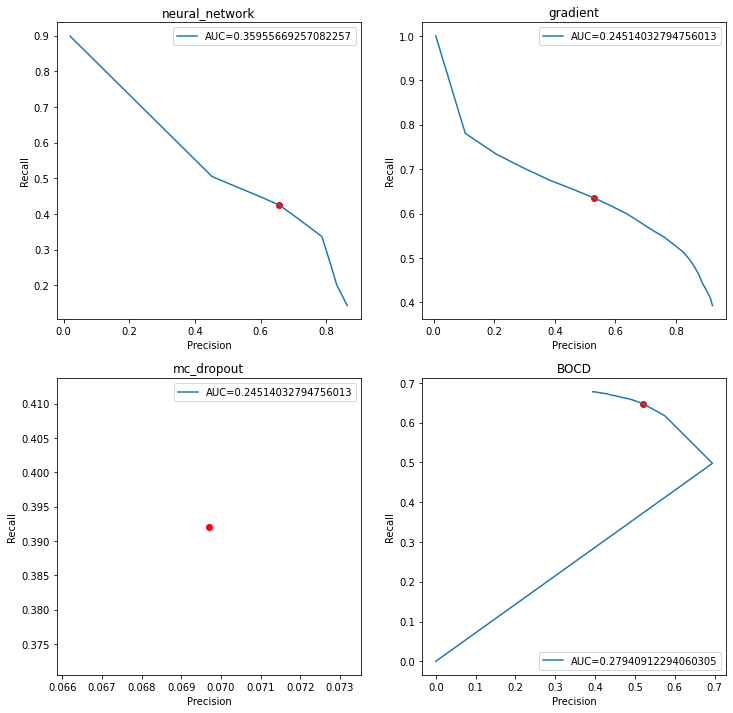

In [27]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    if name!="mc_dropout":
        print(name)
        line1=ax[row,col].plot(df['Precision'], df['Recall'], label="AUC="+str(auc(df['Recall'], df['Precision'])))
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
    df_row=df_summary[df_summary.Name==name]
    ax[row,col].scatter(df_row['Precision'], df_row['Recall'], color='r')
    ax[row,col].legend(handles=line1, loc="best")
plt.show()

In [23]:
precision, recall, thresholds = precision_recall_curve(valid_dataset.data['cps'].unsqueeze(2).float(), model_cpd.cp)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)

ValueError: unknown format is not supported

In [ ]:
precision, recall, thresholds = precision_recall_curve(valid_dataset.data['cps'].unsqueeze(2).float(), model_cpd.cp)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)

# Qualitative by looking at anecdotes/samples

In [ ]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target.detach().cpu().numpy()
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [ ]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(8,1,figsize=[18,30])
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10)
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[2].plot(y_var)
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].plot(pred_cps[cpMethod.neural_network.name])
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    ax[7].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    ax[7].set_title("True Cps")
    plt.show()

In [ ]:
np.sum(pred_cps[cpMethod.mc_dropout.name][3648,:])

In [ ]:
# index = 2000
index = 3648
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

In [ ]:
index = 2620
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

In [ ]:
index = 1200
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

# evaluate on a subset of samples that have at least 1 changepoint 


In [ ]:
subset_idx=torch.unique(torch.nonzero(valid_dataset.data['cps'])[:,0])

In [ ]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'].unsqueeze(2)[subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

# compute metrics by placing win_tol=0

In [ ]:
df_zero_tol=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=valid_dataset.data['cps'].unsqueeze(2).float()
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_zero_tol=df_zero_tol.append(prMetrics, ignore_index=True)
df_zero_tol

# evaluate to make sure matches with scikit learn (subset with samples that have cp, and win_tol=0 for evaluation

In [ ]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'].unsqueeze(2)[subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

# evaluate by Windows

In [ ]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5, byWindows=True)
df_nn.style.background_gradient(cmap="Blues")

In [ ]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1, byWindows=True)
df_grad.style.background_gradient(cmap="Blues")

In [ ]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5, byWindows=True)
df_var.style.background_gradient(cmap="Blues")

In [ ]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20,1,11, byWindows=True)
df_bocd.style.background_gradient(cmap="Blues")

In [ ]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
plt.show()

# load the model and evaluate with test data on the chosen hyperparameters

In [ ]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_11_data_id_3_pca/') 
dataset_type='test'

In [ ]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, test_dataset=test.main(config, params)

# Summary Table with test data

compute BOCD

In [ ]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [ ]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
test_tensor = torch.tensor(y_pred).float()
batch_size_cpd = test_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(test_tensor, 'cpu')

In [ ]:
df_test=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=test_dataset.data['cps'].unsqueeze(2).float()
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_test=df_test.append(prMetrics, ignore_index=True)
df_test